# Imputation time series

> Impute time series using GPFA Leaner

the goal of this notebook is to be able to:

- take a timeseries that contains gaps
- train a GPFA Learner using the available data
- impute the gap, by using the predictions of the learner
- to improve the imputation by conditioning the distribution on the other observation at the same time stamp

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| hide
#| default_exp imputation

In [3]:
from gpfa_imputation.learner import *

import torch

import pandas as pd
import numpy as np
from fastcore.foundation import patch

import matplotlib.pyplot as plt
import altair as alt

In [4]:
torch.manual_seed(27); # set seed for reproducibility of examples

## Fake data 

generate some fake data in order to test the imputation

What is does is:
- take a function to generate the "true" latent
- use some random coefficient to generate all the N features
- add some random noise

In [5]:
#| export
class GPFAFakeData:
    def __init__(self,
                    n_features: int,
                    n_obs: int,
                    latent_func = torch.sin, # Functions used to generate the true latent
                    noise_std = .2,
                    Lambda = None
                ):
        
        self.n_features, self.n_obs = n_features, n_obs
        self.T = torch.arange(n_obs)
        
        self.latent = latent_func(self.T)
        
        self.Lambda = torch.tensor(Lambda).reshape(n_features, 1) if Lambda is not None else torch.rand(n_features, 1)
        
        self.exact_X = (self.Lambda * self.latent).T
        
        self.X =  self.exact_X + torch.normal(0., noise_std, size = (n_obs, n_features)) 
        

In [6]:
fd = GPFAFakeData(3, 4)

In [7]:
fd_plot = pd.DataFrame(fd.X.numpy(), columns = ["x1", "x2", "x3"])
fd_plot["latent"] = pd.Series(fd.latent.numpy())

<AxesSubplot:>

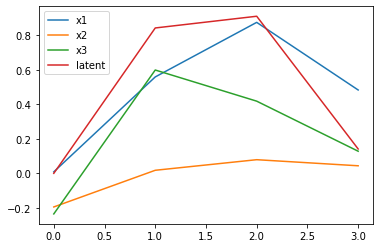

In [8]:
fd_plot.plot()

### Missing Data

add to the fake data class the ability to generate some missing data

In [9]:
# TODO add contigous missing data
@patch()
def add_missing(self: GPFAFakeData,
                prob_miss: float = .2#  Fraction of data that will be missing
               ):
    self.is_miss = torch.rand(self.n_obs) <= prob_miss
    self.X_miss = self.X[~self.is_miss]
    self.T_miss = self.T[~self.is_miss] 
    
    return self


In [10]:
fd.add_missing()

In [11]:
fd.is_miss.to(torch.float).mean() # the mean of this means should be .2

tensor(0.)

In [12]:
fd.X_miss.shape

torch.Size([4, 3])

In [13]:
fd.X.shape

torch.Size([4, 3])

Ideas for improving this class: add_missing should be part of the init, can get the variables with a getter func that can have a miss argument if you want the missing data or no. Otherwise another idea could be to have something the uses the pytorch dataloader api

### Save as DataFrame

In [14]:
# TODO better naming of args
@patch
def as_df(self: GPFAFakeData,
          miss = False, # full dataset (False) or the one without missing data (True)
          tidy=True, # result in tidy (long) format? 
          latent = False, # include latent as column
          add_miss = False #columns to indicate whether the row is missing or not
         ):
    
    df = pd.DataFrame(self.X.numpy(), columns = [f"x{i}" for i in range(self.n_features)])
    df["T"] = self.T
    
    if latent: df["latent"] = pd.Series(self.latent.numpy())
    
    
    id_vars = ["T"]
    
    if add_miss:
        df["is_missing"] = self.is_miss.numpy()
        id_vars.append("is_missing")
    if miss: df = df.loc[~self.is_miss.numpy(), :]

    if tidy: df = df.melt(id_vars)
    return df

In [15]:
fd.as_df()

,T,variable,value
0,0,x0,0.008676
1,1,x0,0.558043
2,2,x0,0.873847
3,3,x0,0.482526
4,0,x1,-0.194478
5,1,x1,0.017782
6,2,x1,0.079032
7,3,x1,0.043834
8,0,x2,-0.234784
9,1,x2,0.598060


In [16]:
fd.as_df(miss=True)

,T,variable,value
0,0,x0,0.008676
1,1,x0,0.558043
2,2,x0,0.873847
3,3,x0,0.482526
4,0,x1,-0.194478
5,1,x1,0.017782
6,2,x1,0.079032
7,3,x1,0.043834
8,0,x2,-0.234784
9,1,x2,0.598060


In [17]:
fd.as_df(tidy=False)

,x0,x1,x2,T
0,0.008676,-0.194478,-0.234784,0
1,0.558043,0.017782,0.598060,1
2,0.873847,0.079032,0.417802,2
3,0.482526,0.043834,0.128108,3


In [18]:
fd.as_df(latent=True)

,T,variable,value
0,0,x0,0.008676
1,1,x0,0.558043
2,2,x0,0.873847
3,3,x0,0.482526
4,0,x1,-0.194478
5,1,x1,0.017782
6,2,x1,0.079032
7,3,x1,0.043834
8,0,x2,-0.234784
9,1,x2,0.598060


In [19]:
fd.as_df(add_miss=True)

,T,is_missing,variable,value
0,0,False,x0,0.008676
1,1,False,x0,0.558043
2,2,False,x0,0.873847
3,3,False,x0,0.482526
4,0,False,x1,-0.194478
5,1,False,x1,0.017782
6,2,False,x1,0.079032
7,3,False,x1,0.043834
8,0,False,x2,-0.234784
9,1,False,x2,0.598060


The export as a dataframe is working correctly with the missing data

In [20]:
fd_df = fd.as_df()

In [21]:
alt.Chart(fd_df).mark_line(point=True).encode(
    x = "T",
    y = "value",
    color = "variable"
)

alt.Chart(...)

In [22]:
alt.Chart(fd.as_df(miss=True)).mark_line(point=True).encode(
    x = "T",
    y = "value",
    color = "variable"
)

alt.Chart(...)

## GPFA Imputation

This is the core class that does the imputation using a GPFA

The inputs is:

- a dataframe containing the observed data, where the row with missing data have been removed
- a vector of times where the data is missing

it returns:

- a complete dataframe with the prediction of the model

The goal is that `GPFAImputation` takes as imput a dataframe containing missing values and then it imputes them using GPFALearner.
Therefore it needs to divide the dataframe in 3 sections:

- training data (rows with no NAs)
- times to be imputed (rows with some NAs)
- observations (variables in the pred rows that are not missing) for conditional predictions

In [23]:
t_df = pd.DataFrame([
    [1., 3., 4.],
    [2., 6., np.nan],
    [np.nan, np.nan, np.nan],
    [np.nan, 8., np.nan],
    [3., 4., 5.]
]
)

In [24]:
train_idx = ~t_df.isna().any(1)

In [25]:
t_df[train_idx]

,0,1,2
0,1.0,3.0,4.0
4,3.0,4.0,5.0


In [26]:
pred_data = t_df[~train_idx].to_numpy() 

In [27]:
pred_data

array([[ 2.,  6., nan],
       [nan, nan, nan],
       [nan,  8., nan]])

In [28]:
idx_cond = ~t_df[~train_idx].isna()

In [29]:
idx_cond

,0,1,2
1,True,True,False
2,False,False,False
3,False,True,False


In [30]:
idx_cond = idx_cond.to_numpy().flatten() # learner needs a 1D index

In [31]:
obs = pred_data.flatten()[idx_cond]

In [32]:
obs

array([2., 6., 8.])

In [33]:
train_idx = t_df.isna().any(1)

In [34]:
torch.tensor(~t_df[~train_idx].isna().to_numpy().flatten())

tensor([True, True, True, True, True, True])

Implement this into a function

In [35]:
#| export
class GPFAImputation:
    def __init__(
        self,
        data: pd.DataFrame , #observed data with missing data as NA
    ):
        self.data = data
        self.T = torch.arange(0, len(data), dtype=torch.float32) # time is encoded with a increase of 1
        
        # Training data
        self.train_idx = ~self.data.isna().any(1)
        self.train_data = torch.tensor(self.data[self.train_idx].to_numpy())
        self.train_T = self.T[self.train_idx]
        
        self.learner = GPFALearner(X = self.train_data, T = self.train_T)

        # Prediction data
        self.pred_T = self.T[~self.train_idx]
        self.cond_idx = torch.tensor(~self.data[~self.train_idx].isna().to_numpy().flatten()) # conditional obsevations
        self.cond_obs = torch.tensor(self.data[~self.train_idx].to_numpy().flatten()[self.cond_idx])
        
        
    def impute(self,
               add_time = True, # add column with time?
               tidy = True # tidy data?
               ):
        self.learner.train()
        self.pred = self.learner.predict(self.pred_T, obs = self.cond_obs, idx = self.cond_idx)
        
        if tidy: return self._impute_tidy(add_time)
        else: return self._impute_wide(add_time)
        
        
    def _impute_wide(self, add_time):
        """ Impute in wide format"""
        
        imp_data = self.data.copy()
        for col_idx, col_name in enumerate(imp_data.columns):
            imp_data.loc[~self.train_idx, col_name] = self.pred.mean[:, col_idx].numpy()
            imp_data.loc[~self.train_idx, col_name + "_std"] = self.pred.std[:, col_idx].numpy()
        
        idx_vars = []
        if add_time:
            imp_data["time"] = self.T
            idx_vars.append("time")
        
        return imp_data 
    
    def _impute_tidy(self, add_time):
        """ transform the pred output into a tidy dataframe suitable for plotting"""
        feature_names = self.data.columns

        pred_mean = pd.DataFrame(self.pred.mean, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="mean")
        pred_std = pd.DataFrame(self.pred.std, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="std")
        
        pred = pd.merge(pred_mean, pred_std, on=['time', 'variable'])  
        
        train_data = self.data[self.train_idx].assign(time = self.train_T).melt("time", value_name = "mean")
               
        pred = pd.concat((train_data, pred))
        
        self.pred_tidy = pred 
        return pred 
    

In [36]:
fd = GPFAFakeData(2, 10, Lambda=[1,2.]).as_df(tidy=False).drop("T", axis=1)

fd[8:] = np.nan # manually add some missing values
fd.iloc[7, 0] = np.nan
fd

,x0,x1
0,-0.151843,0.041360
1,0.707272,1.774958
2,1.220836,1.639830
3,0.065848,0.278568
4,-0.743248,-1.678350
5,-1.043636,-1.852417
6,-0.574820,-0.545305
7,NaN,1.137419
8,NaN,NaN
9,NaN,NaN


In [37]:
imp = GPFAImputation(fd)

In [38]:
pred = imp.impute()
pred

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: operator() profile_node %840 : int[] = prim::profile_ivalue(%838)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ eng

,time,variable,mean,std
0,0.0,x0,-0.151843,NaN
1,1.0,x0,0.707272,NaN
2,2.0,x0,1.220836,NaN
3,3.0,x0,0.065848,NaN
4,4.0,x0,-0.743248,NaN
5,5.0,x0,-1.043636,NaN
6,6.0,x0,-0.574820,NaN
7,0.0,x1,0.041360,NaN
8,1.0,x1,1.774958,NaN
9,2.0,x1,1.639830,NaN


In [39]:
imp.impute(tidy=False)

,x0,x1,x0_std,x1_std,time
0,-0.151843,0.041360,NaN,NaN,0.0
1,0.707272,1.774958,NaN,NaN,1.0
2,1.220836,1.639830,NaN,NaN,2.0
3,0.065848,0.278568,NaN,NaN,3.0
4,-0.743248,-1.678350,NaN,NaN,4.0
5,-1.043636,-1.852417,NaN,NaN,5.0
6,-0.574820,-0.545305,NaN,NaN,6.0
7,0.550473,1.137419,0.190508,0.000000,7.0
8,0.966047,1.821875,0.402892,0.689609,8.0
9,0.727238,1.392444,0.728918,1.291802,9.0


### Prediction plot

In [40]:
@patch()
def plot_pred(
    self: GPFAImputation,
    truth = None # Optional true data to be plotted agaist predictions
):
    
    if not hasattr(self, "pred_tidy"): self.predict()
    
    error = alt.Chart(self.pred_tidy).mark_errorband().encode(
        x = "T",    
        y = alt.Y("err_low:Q", title=""),
        y2 = "err_high:Q",
        color="variable"
    ).transform_calculate(
        err_low = "datum.mean - 2 * datum.std",
        err_high = "datum.mean + 2 * datum.std"
    )

    pred = alt.Chart(self.pred_tidy).mark_line().encode(
        x = "T",    
        y = alt.Y("mean:Q", title="value variable"),
        color="variable"
    )

    plot = error + pred
    
    if truth is not None:
        
        truth_plt = alt.Chart(truth).mark_point().encode(
            x = "T",
            y = alt.Y("value", title="value variable"),
            color="variable",
            shape = "is_missing"
        )
        
        plot = plot + truth_plt
    
    
    return plot

In [41]:
imp.plot_pred(fd.as_df(miss=False, add_miss=True))

AttributeError: 'DataFrame' object has no attribute 'as_df'

check the code works without true values

In [ ]:
imp.plot_pred()

The code is running correctly and as expected around the missing data point the error is band is wider

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()